In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import multivariate_normal as mv_normal
from tqdm import tqdm

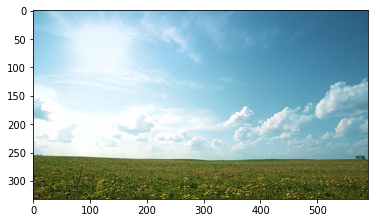

In [2]:
#Завантажити зображення

#img = plt.imread("zhyto.jpg")
#img = plt.imread("more.jpg")
#img = plt.imread("pole1.jpg")
#img = plt.imread("pole2.jpg")
#img = plt.imread("pole3.jpg")
img = plt.imread("image.jpg")
#img = plt.imread("shtorm.jpeg")
plt.imshow(img)

# 1. Початкова ініціалізація параметрів

$ p_0 = p_1 = \frac{1}{2} $ - ймовірність сегментів <br>
$ \mu_0, \mu_1 $ - вектори середнього (у просторі RGB) <br>
$ K_0, K_1 $ - коваріаційні матриці (у просторі RGB) <br>

In [3]:
p_0 = 0.5
p_1 = 0.5

mean_1 = np.array([235,235,235])
mean_0 = np.array([20,20,0])

cov_0 = np.array([[150*150, 50*50, 100*100],[50*50, 150*150, 80*80],[100*100, 80*80, 150*150]])
cov_1 = np.array([[150*150, 50*50, 100*100],[50*50, 150*150, 80*80],[100*100, 80*80, 150*150]])

# 2. Власне, EM-алгоритм
2a крок. Обчислення $p(k / x_i,a_k^{t}) $
$$ \alpha^{t} (i, k) = \cfrac{p_K^{t}(k) f(x_i, a_k^{t})}{\sum_{k' \in K} p_K^{t} f(x_i, a_k^{t})} $$ <br>

2b крок. Expectation - обчислення ймовірностей кластерів <br>
$$ p_K^{t+1} (k) = \cfrac{\sum_{i=1}^n \alpha^{t}(i,k)}{n} $$

2c крок. Maximization - оновлення параметрів нормальних розподілів сегментів <br>
$$ \mu_k^{t+1}, K_k^{t+1} = argmax_{\mu_k, K_k} \sum_{i=1}^{n} \alpha^{t} (i,k) log ( f(x_i, \mu_k, K_k) )$$

На лекції доводили, що argmax досягається за таких умов: <br>
$$ \mu_k = \cfrac{\sum_{i=1}^{n}\alpha_i (k) x_i}{\sum_{i=1}^{n} \alpha_i (k)} $$ <br> 
$$ K_k = \cfrac{\sum_{i=1}^{n} \alpha_i (k) (x_i - \mu_k) (x_i - \mu_k)^{T} }{\sum_{i=1}^{n} \alpha_i(k) } $$ <br> <br>

In [4]:
from tqdm import tqdm

In [5]:
#EM - алгоритм
n_iter = 100
for it in tqdm(range(n_iter)):
    #обчислення f(x_i, a_k)
    dens_arr0 = mv_normal.pdf(img, mean_0, cov_0)
    dens_arr1 = mv_normal.pdf(img, mean_1, cov_1)
    
    #обчислення alpha(i,k). 2a крок
    alphas_0 = p_0*dens_arr0
    alphas_1 = p_1*dens_arr1
    sum_alphas = alphas_0 + alphas_1
    alphas_0 = alphas_0/sum_alphas
    alphas_1 = alphas_1/sum_alphas
    
    #обчислення p_0, p_1. Expectation крок. 2b крок
    p_0 = alphas_0.mean()
    p_1 = alphas_1.mean()
    
    #оновлення mu_0, mu_1. Maximization крок. 2c крок
    alphas_0_temp = np.zeros(img.shape)
    alphas_1_temp = np.zeros(img.shape)
    for s in [0,1,2]:
        alphas_0_temp[:,:,s] = alphas_0
        alphas_1_temp[:,:,s] = alphas_1
    mean_0 = ( (alphas_0_temp * img).sum( axis=(0,1) ))/(alphas_0.sum())
    mean_1 = ( (alphas_1_temp * img).sum( axis=(0,1) ))/(alphas_1.sum())
    
    #if(it%10==0):
    #    print(f"{it}: mean0: {mean_0}, mean1:{mean_1} ")
    #    print(f"{it}: cov0: {cov_0}, cov1: {cov_1} ")
    
    #оновлення K_0, K_1. Maximization крок. 2с крок
    alphas_0_temp = np.sqrt(alphas_0_temp)
    numerator0 = ((alphas_0_temp)*(img - mean_0)).reshape(3,-1)
    numerator0 = numerator0 @ numerator0.T
    cov_0 = numerator0/(alphas_0.sum())
    
    alphas_1_temp = np.sqrt(alphas_1_temp)
    numerator1 = ((alphas_1_temp)*(img - mean_1)).reshape(3,-1)
    numerator1 = numerator1 @ numerator1.T
    cov_1 = numerator1/(alphas_1.sum())

100%|██████████| 100/100 [00:09<00:00, 10.53it/s]


In [6]:
mean_0, mean_1

(array([ 91.37810039, 129.4821319 , 124.20682661]),
 array([206.74542955, 231.46853551, 241.97510341]))

In [7]:
cov_0, cov_1

(array([[1910.09135446,  -86.84058279, -153.93294666],
        [ -86.84058279, 1592.57229596, -557.98950032],
        [-153.93294666, -557.98950032, 5253.04379274]]),
 array([[ 535.46398466, -128.72214892,   50.19722487],
        [-128.72214892,  748.06323437,  -55.84710039],
        [  50.19722487,  -55.84710039,  300.87666358]]))

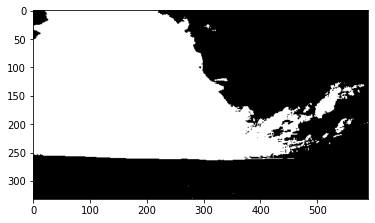

In [8]:
# побудуємо просту сегментацію, використовуючи параметри надані ЕМ-алгоритмом
from scipy.stats import multivariate_normal as mv_normal
mask = (mv_normal.pdf(img,mean_1,cov_1)>mv_normal.pdf(img,mean_0,cov_0)).astype('int')
plt.imshow( mask, cmap='gray' )

# Отримані параметри розподілів передаємо далі у семплер Гіббса, уточнюємо сегментацію

100%|██████████| 100/100 [00:13<00:00,  7.28it/s]

CPU times: user 12.5 s, sys: 1.3 s, total: 13.8 s
Wall time: 13.8 s


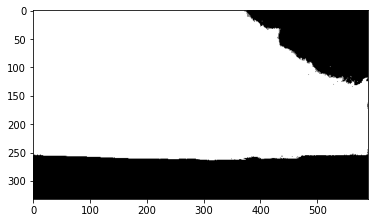

In [9]:
%%time
#eps = 0.9
#eps = 0.5
#eps = 0.2
eps = 0.1
#eps = 0.05
#eps = 0.02
#eps = 0.01

#в директорию iters - запишем промежуточные итерации
os.system("rm -r iters")
os.mkdir("iters")

#будет нужно во время вычисления вероятностей
def invert_mask(m):
    return (m==1) + eps*(m==1-eps) + (1-eps)*(m==eps)

n_iter = 100

for j in tqdm(range(n_iter)):
    
    #проверяем сходство каждого пикселя с пикселем слева. Если слева пикселя нет, ставим единицу.
    mask_left = np.ones( mask.shape )
    mask_left[:,1:] = (mask[:,1:]==mask[:,:-1] )*(1-eps) + (mask[:,1:]!=mask[:,:-1])*(eps)
    inv_mask_left = invert_mask(mask_left) #инвертированная маска
    
    #проверяем сходство каждого пикселя с пикселем справа. Если справа пикселя нет, ставим единицу.
    mask_right = np.ones( mask.shape )
    mask_right[:,:-1] = (mask[:,:-1]==mask[:,:1])*(1-eps) + (mask[:,:-1]!=mask[:,:1])*(eps)
    inv_mask_right = invert_mask(mask_right)
    
    #проверяем сходство каждого пикселя с пикселем сверху. Если сверху пикселя нет, ставим единицу.
    mask_up = np.ones( mask.shape )
    mask_up[1:,:] = (mask[1:,:]==mask[:-1,:])*(1-eps) + (mask[1:,:]!=mask[:-1,:])*(eps)
    inv_mask_up = invert_mask(mask_up)
    
    #проверяем сходство каждого пикселя с пикселем снизу. Если пикселя снизу нет, ставим единицу.
    mask_down = np.ones(mask.shape)
    mask_down[:-1, :] = (mask[:-1,:]==mask[1:,:])*(1-eps) + (mask[:-1,:]!=mask[1:,:])*(eps)
    inv_mask_down = invert_mask(mask_down)
    
    #Вычисляем матрицу вероятностей нулей и единиц для каждого пикселя 
    # (при условии собственного цвета, и известных меток соседей)
    #p0_mat = mv_normal.pdf(img,m0,cov0)*mask_left*mask_right*mask_up*mask_down
    p0_mat = mv_normal.pdf(img, mean_0, cov_0)
    p0_mat = p0_mat*( (mask==0)*mask_left*mask_right*mask_up*mask_down + (mask==1)*inv_mask_left*inv_mask_right*inv_mask_up*inv_mask_down )
    
    #p1_mat = mv_normal.pdf(img,m1,cov1)*mask_left*mask_right*mask_up*mask_down
    p1_mat = mv_normal.pdf(img, mean_1, cov_1)
    p1_mat = p1_mat*( (mask==1)*mask_left*mask_right*mask_up*mask_down + (mask==0)*inv_mask_left*inv_mask_right*inv_mask_up*inv_mask_down ) 
    
    s_mat = p0_mat+p1_mat
    p0_mat = p0_mat/s_mat
    p1_mat = p1_mat/s_mat
    
    #Переходим к генерации самих меток.
    #теперь для каждого пикселя имеем p(0/x), p(1/x)
    #Y ~ U[0,1] . Y>p(0/x) -> метка 1, Y<=p(0/x) -> метка 0.
    prob_mat = np.random.uniform(low=0.0, high = 1.0, size = mask.shape)
    mask = (prob_mat > p0_mat).astype('int')
    plt.imsave(fname = f"iters/iter_em_plus_gibbs{j}", arr=mask, cmap='gray', format='png' )
    
    pixels0 = img[mask==0]
    pixels1 = img[mask==1]
    #обновляем параметры гауссовского распределения
    mean_0 = pixels0.mean(axis = 0)
    mean_1 = pixels1.mean(axis = 0)
    cov_0 = np.cov( pixels0, rowvar = False) 
    cov_1 = np.cov( pixels1, rowvar = False) 
    
plt.imshow(mask, cmap='gray')